#### Vanilla VAE

Demonstrates MNIST reconstruction and hidden variable representation.

In [1]:
%pylab inline
import matplotlib.pyplot as plt
from vanilla_vae import *

/Users/wellecks/own_files/env/minpy_dev/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


#### MNIST Reconstruction

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

data = input_data.read_data_sets('data')
data_dim = data.train.images.shape[1]

enc_h = 128
enc_z = 64
dec_h = 128
max_iters = 5000
batch_size = 100
learning_rate = 0.01

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [3]:
tf.reset_default_graph()

In [4]:
x, e = inputs(data_dim, enc_z)
mu, log_var, z = encoder(x, e, data_dim, enc_h, enc_z)
out_op, out_mu, out_log_var = decoder(z, data_dim, dec_h, enc_z)
loss_op = make_loss(out_op, x, log_var, mu, out_log_var)
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss_op)

sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

In [5]:
x_test, _ = data.test.next_batch(1)
recons = []

for i in xrange(max_iters):
    x_, y_ = data.train.next_batch(batch_size)
    l = train_step(sess, x_, train_op, loss_op, x, e, enc_z)
    if i % 1000 == 0:
        print('iter: %d\tloss: %.2f' % (i, l))
        recons.append(reconstruct(sess, x_test, out_op, x, e, enc_z)[0])

iter: 0	loss: 4661.12
iter: 1000	loss: 361.01
iter: 2000	loss: 304.80
iter: 3000	loss: 334.77
iter: 4000	loss: 303.95


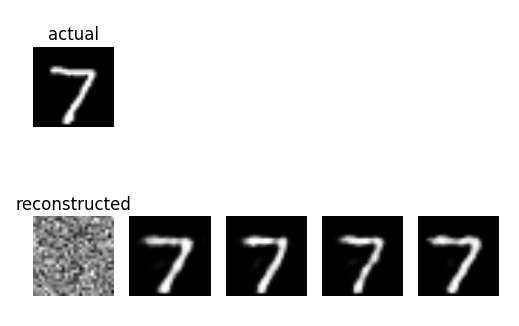

In [6]:
actual = x_test[0]
fig, axs = plt.subplots(2, len(recons))
for i, recon in enumerate(recons):
    axs[0, 0].imshow(actual.reshape(28, 28), cmap='gray')
    axs[1, i].imshow(recon.reshape(28, 28), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].axis('off')
axs[0, 0].set_title('actual')
axs[1, 0].set_title('reconstructed');

#### Image reconstruction widget

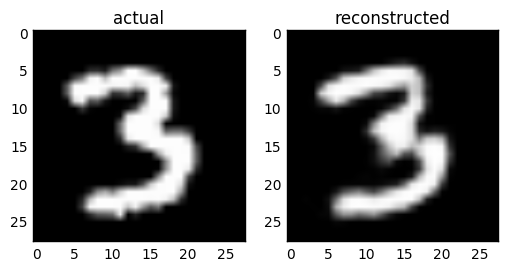

In [7]:
from ipywidgets import interact
n = 1000
images = data.test.next_batch(n)[0]
reconstructed = reconstruct(sess, images, out_op, x, e, enc_z)[0]

def browse(i):
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(images[i].reshape(28, 28), cmap='gray')
    axs[1].imshow(reconstructed[i].reshape(28, 28), cmap='gray')
    axs[0].set_title('actual')
    axs[1].set_title('reconstructed')
    plt.show()

interact(browse, i=(0, n-1));

#### Hidden Variable visualization

Train with 2d latent space

In [8]:
tf.reset_default_graph()

In [9]:
data = input_data.read_data_sets('data')
data_dim = data.train.images.shape[1]

enc_h = 128
enc_z = 2
dec_h = 128
max_iters = 10000
batch_size = 100
learning_rate = 0.001

x, e = inputs(data_dim, enc_z)
mu, log_var, z = encoder(x, e, data_dim, enc_h, enc_z)
out_op, out_mu, out_log_var = decoder(z, data_dim, dec_h, enc_z)
loss_op = make_loss(out_op, x, log_var, mu, out_log_var)
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss_op)

sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [10]:
for i in xrange(max_iters):
    x_, y_ = data.train.next_batch(batch_size)
    l = train_step(sess, x_, train_op, loss_op, x, e, enc_z)
    if i % 1000 == 0:
        print('iter: %d\tloss: %.2f' % (i, l))

iter: 0	loss: 4552.34
iter: 1000	loss: 1053.43
iter: 2000	loss: 1025.30
iter: 3000	loss: 888.86
iter: 4000	loss: 841.34
iter: 5000	loss: 860.12
iter: 6000	loss: 919.09
iter: 7000	loss: 862.28
iter: 8000	loss: 868.24
iter: 9000	loss: 832.49


Visualizing learned representation space

In [11]:
x_, y_ = data.train.next_batch(5000)
e_ = np.random.normal(size=(x_.shape[0], enc_z))
zs = sess.run(z, feed_dict={x: x_, e: e_})

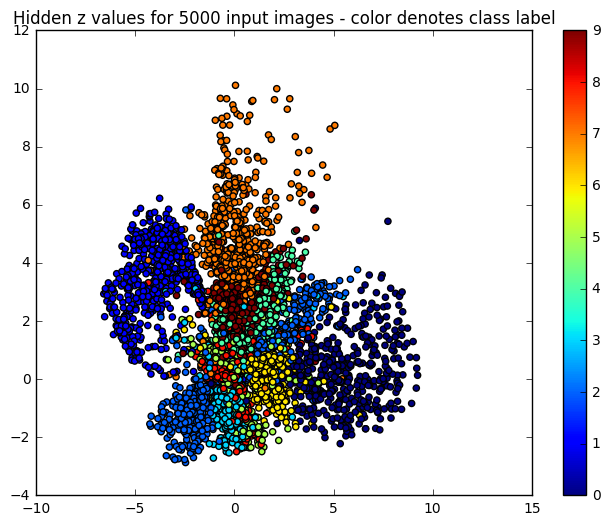

In [12]:
fig = plt.figure(figsize=(8, 6));
plt.scatter(zs[:, 0], zs[:, 1], c=y_)
plt.colorbar();
plt.title('Hidden z values for %d input images - color denotes class label' % x_.shape[0])
plt.show();

Decode images with latent points from across a 2d grid

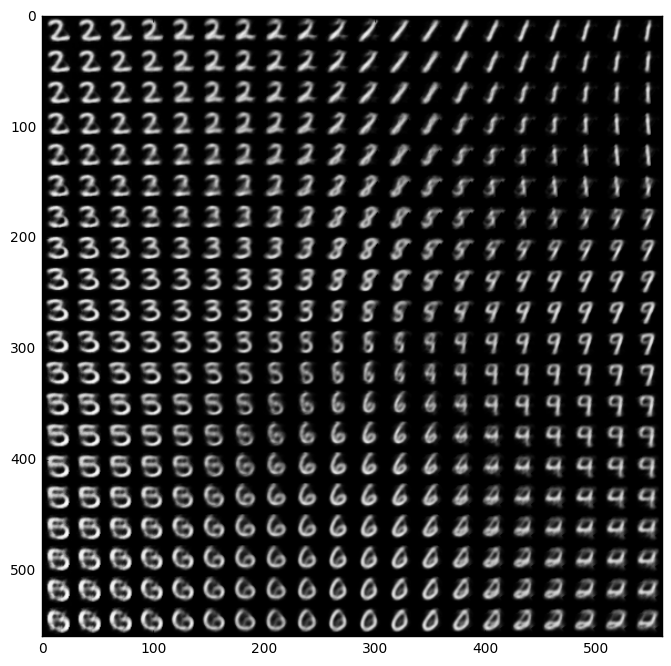

In [13]:
num_x, num_y = 20, 20
x_dom = np.linspace(-3, 3, num_x)
y_dom = np.linspace(-3, 3, num_y)

canvas = np.empty((28*num_x, 28*num_y))
for i, xi in enumerate(x_dom):
    for j, yj in enumerate(y_dom):
        x_hat = sess.run(out_op, feed_dict={z: np.array([[xi, yj]])})
        canvas[28*i:28*(i+1), 28*j:28*(j+1)] = x_hat.reshape(28, 28)

plt.figure(figsize=(8, 8))
plt.imshow(canvas, cmap='gray');

#### Posterior Visualization for 4-datapoint dataset

Notice `out_fn=tf.identity` in the decoder, since we don't necessarily want output in [0,1] like in MNIST

In [14]:
data = np.array([[-10.,-10.], [-10., 10.], [10., -10.], [10., 10.]])

In [15]:
tf.reset_default_graph()

data_dim = 2

enc_h = 128
enc_z = 2
dec_h = 128
max_iters = 15000
batch_size = 4
learning_rate = 0.001

x, e = inputs(data_dim, enc_z)
mu, log_var, z = encoder(x, e, data_dim, enc_h, enc_z)
out_op, out_mu, out_log_var = decoder(z, data_dim, dec_h, enc_z, out_fn=tf.identity)
loss_op = make_loss(out_op, x, log_var, mu, out_log_var)
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss_op)

sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

In [16]:
idx = 0
for i in xrange(max_iters):
    x_ = data[idx:idx+batch_size]
    l = train_step(sess, x_, train_op, loss_op, x, e, enc_z)
    idx += batch_size
    if idx >= x_.shape[0]:
        idx = 0
    if i % 1000 == 0:
        print('iter: %d\tloss: %.2f' % (i, l))

iter: 0	loss: 204.27
iter: 1000	loss: 6.97
iter: 2000	loss: 7.01
iter: 3000	loss: 6.56
iter: 4000	loss: 6.17
iter: 5000	loss: 5.76
iter: 6000	loss: 4.72
iter: 7000	loss: 4.39
iter: 8000	loss: 4.68
iter: 9000	loss: 4.35
iter: 10000	loss: 3.43
iter: 11000	loss: 4.32
iter: 12000	loss: 3.42
iter: 13000	loss: 3.16
iter: 14000	loss: 2.80


Forward each of the four data points to get posterior parameters, then sample from the posteriors:

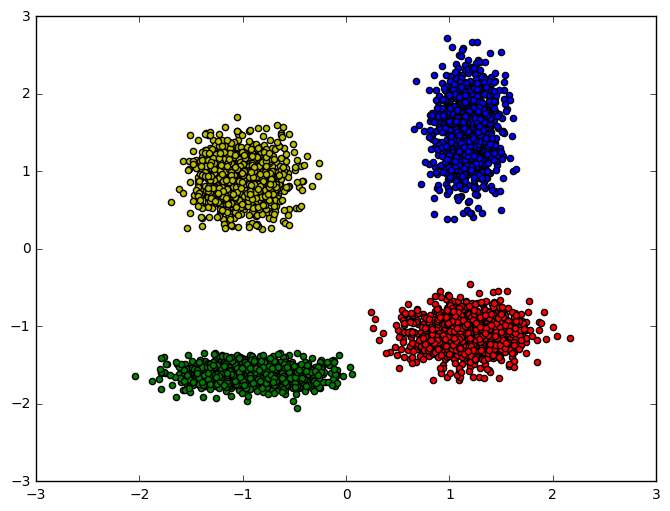

In [17]:
x_ = data
y_ = data.shape[0]
e_ = np.random.normal(size=(x_.shape[0], enc_z))
mus, lvs = sess.run([mu, log_var], feed_dict={x: x_, e: e_})

fig = plt.figure(figsize=(8, 6));
c = ['r', 'g', 'b', 'y']
for i, (m, v) in enumerate(zip(mus, lvs)):
    d = np.random.multivariate_normal(m, np.diag(np.exp(v)), size=1000)
    plt.scatter(d[:, 0], d[:, 1], c=c[i])
    plt.hold(True)
plt.show();

Sampling with reparameterization trick

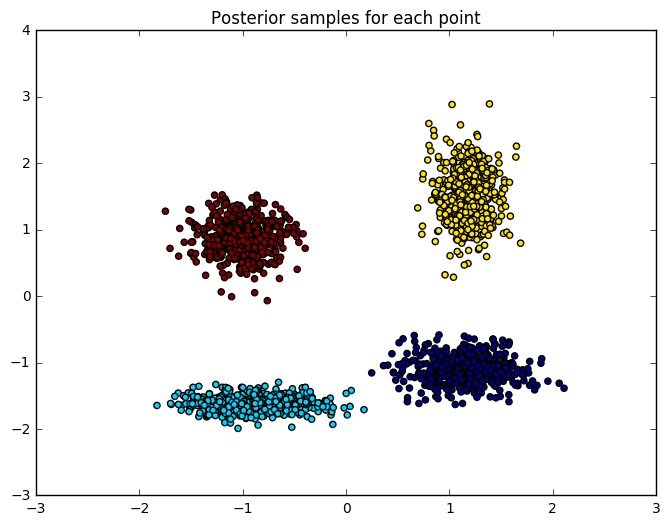

In [18]:
k = 500

x_ = np.repeat(data, 500, axis=0)
y_ = np.repeat(np.arange(data.shape[0]), 500)
e_ = np.random.normal(size=(x_.shape[0], enc_z))
zs = sess.run(z, feed_dict={x: x_, e: e_})

fig = plt.figure(figsize=(8, 6));
plt.scatter(zs[:, 0], zs[:, 1], c=y_)

plt.title("Posterior samples for each point")
plt.show();

#### Posterior Visualization for Mixture Model

Generate and show the data

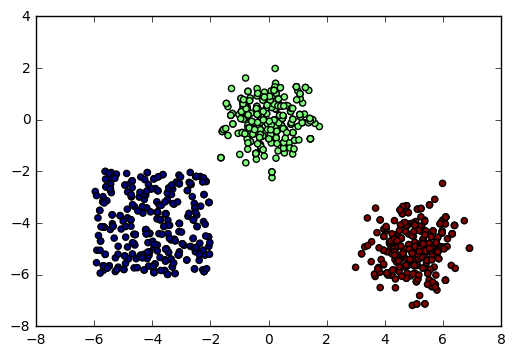

In [19]:
N = 1000
xs = np.vstack((
    np.random.uniform(-6, -2, size=(N/3, 2)),
    np.random.multivariate_normal([0, 0], np.eye(2)/2, size=N/3),
    np.random.multivariate_normal([5, -5], np.eye(2)/2, size=N/3)
))
ys = np.repeat(np.arange(3), N/3)


idxs = np.random.choice(range(xs.shape[0]), xs.shape[0])
xs, ys = xs[idxs], ys[idxs]

plt.scatter(xs[:, 0], xs[:, 1], c=ys);

In [20]:
tf.reset_default_graph()

data = xs
data_dim = xs.shape[1]

enc_h = 128
enc_z = 2
dec_h = 128
max_iters = 10000
batch_size = 10
learning_rate = 0.001

x, e = inputs(data_dim, enc_z)
mu, log_var, z = encoder(x, e, data_dim, enc_h, enc_z)
out_op, out_mu, out_log_var = decoder(z, data_dim, dec_h, enc_z, out_fn=tf.identity)
loss_op = make_loss(out_op, x, log_var, mu, out_log_var)
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss_op)

sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

idx = 0
for i in xrange(max_iters):
    x_ = data[idx:idx+batch_size]
    l = train_step(sess, x_, train_op, loss_op, x, e, enc_z)
    idx += batch_size
    if idx >= x_.shape[0]:
        idx = 0
    if i % 1000 == 0:
        print('iter: %d\tloss: %.2f' % (i, l))

iter: 0	loss: 48.12
iter: 1000	loss: 4.58
iter: 2000	loss: 4.35
iter: 3000	loss: 4.79
iter: 4000	loss: 3.83
iter: 5000	loss: 4.00
iter: 6000	loss: 3.49
iter: 7000	loss: 3.65
iter: 8000	loss: 3.07
iter: 9000	loss: 3.65


Reconstruct Data

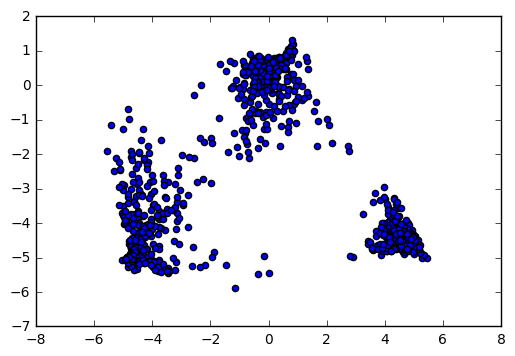

In [21]:
reconstructed = reconstruct(sess, data, out_op, x, e, enc_z)[0]
plt.scatter(reconstructed[:, 0], reconstructed[:, 1]);

#### Explicit sampling using `mu` and `log_var`

Choose a data point from each class, forward to get posterior parameters, sample from a multivariate Gaussian, and plot the samples

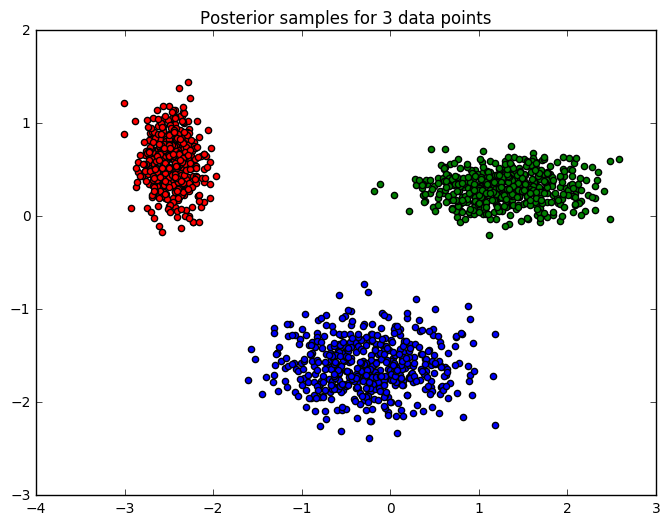

In [22]:
# Take a data point from each class
x_ = data[[(ys==i).argmax() for i in range(3)]]
y_ = np.arange(3)
e_ = np.random.normal(size=(x_.shape[0], enc_z))
mus, lvs = sess.run([mu, log_var], feed_dict={x: x_, e: e_})

fig = plt.figure(figsize=(8, 6));
c = ['b', 'g', 'r']
for i, (m, v) in enumerate(zip(mus, lvs)):
    d = np.random.multivariate_normal(m, np.diag(np.exp(v)), size=500)
    plt.scatter(d[:, 0], d[:, 1], c=c[i])
    plt.hold(True)

plt.title("Posterior samples for 3 data points")
plt.show();

#### Sampling using reparameterization trick


To get `k` samples for a data point, copy it `k` times, then forward with `k` different noise samples

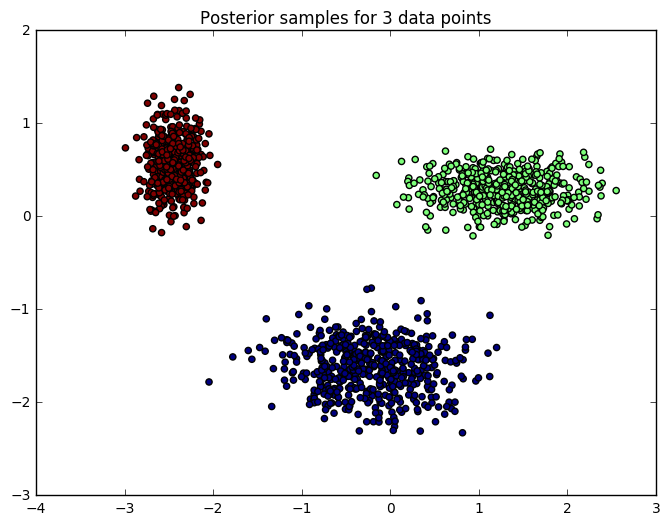

In [23]:
k = 500

# Take a data point from each class
x_ = np.repeat(data[[(ys==i).argmax() for i in range(3)]], 500, axis=0)
y_ = np.repeat(np.arange(3), 500)
e_ = np.random.normal(size=(x_.shape[0], enc_z))
zs = sess.run(z, feed_dict={x: x_, e: e_})

fig = plt.figure(figsize=(8, 6));
plt.scatter(zs[:, 0], zs[:, 1], c=y_)

plt.title("Posterior samples for 3 data points")
plt.show();